## Import modules

In [44]:
import os
import pandas as pd
import numpy as np

import datetime
from dateutil.relativedelta import relativedelta

import seaborn as sns
from bokeh.plotting import figure, show, output_notebook
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm  

from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose

os.chdir('/Users/Evan/DataScience/TB_Nation/Datasets//')
files = os.listdir()

## Getting and cleaning data

In [45]:
datasets = pd.DataFrame()
for i in range(1,len(files)):
    for j in os.listdir(files[i]):
        data = pd.read_excel(files[i]+'/'+ j ,skiprows=1).iloc[:1,0:5]
        data = data.rename(columns={'Unnamed: 0':'Area','发病数':'Incidence','死亡数':'Death','发病率':'Incidence_rate','死亡率':'Death_rate'})
        data['Year'],data['Month'],data['Day'] = files[i],j[4:6],'01'
        datasets = pd.concat([datasets,data])
# datasets.index=range(0,len(datasets))
datasets['Date'] = datasets['Year'] + datasets['Month'] + datasets['Day']
datasets.index = pd.to_datetime(datasets['Date'])
datasets = datasets.drop(['Day','Date'],axis=1)
datasets.shape

(132, 7)

In [46]:
datasets.to_excel('/Users/Evan/Desktop/TB_nation.xlsx')

## Exploratory Data analysis

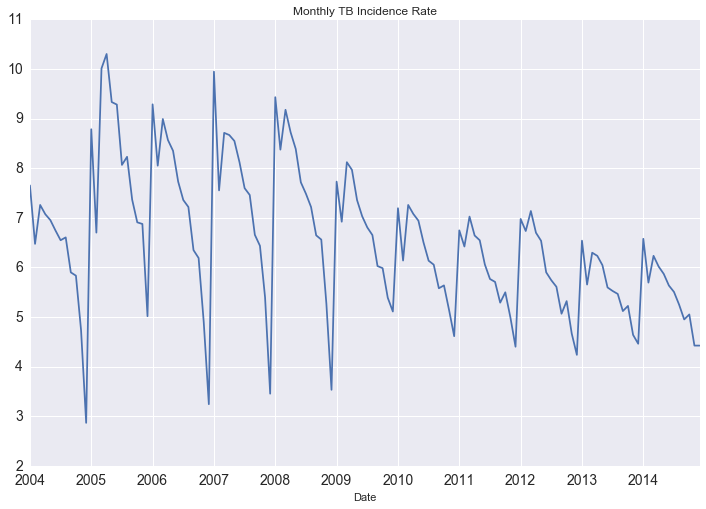

In [47]:
datasets.Incidence_rate.plot(figsize=(12,8), title= 'Monthly TB Incidence Rate', fontsize=14)
# plt.savefig('month_TB.png', bbox_inches='tight')

In [48]:
datasets_pred = datasets[datasets.index>='2013-01-1']
datasets = datasets[datasets.index<'2013-01-01']
datasets.shape
datasets_pred

,Area,Incidence,Death,Incidence_rate,Death_rate,Year,Month
Date,,,,,,,
2013-01-01,全 国,88539,233,6.538876,0.017208,2013,01
2013-02-01,全 国,76557,216,5.653969,0.015952,2013,02
2013-03-01,全 国,85255,238,6.296343,0.017577,2013,03
2013-04-01,全 国,84395,211,6.232829,0.015583,2013,04
2013-05-01,全 国,81852,237,6.045021,0.017503,2013,05
2013-06-01,全 国,75769,205,5.595773,0.015140,2013,06
2013-07-01,全 国,74805,247,5.524578,0.018242,2013,07
2013-08-01,全 国,73995,203,5.464757,0.014992,2013,08
2013-09-01,全 国,69323,206,5.119716,0.015214,2013,09


In [49]:
decomposition = seasonal_decompose(datasets.Incidence_rate,freq=12)

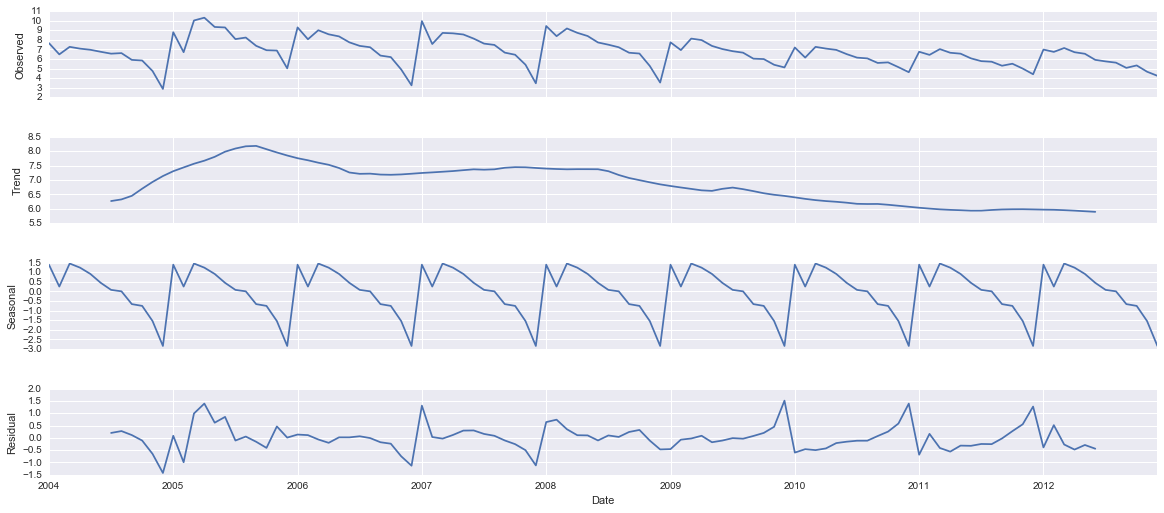

In [50]:
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(18,8)

## SARIMA

### Test of stationarity

In [51]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
#     rolmean = pd.rolling_mean(timeseries, window=12)
    rolmean = timeseries.rolling(window=12,center=False).mean()
#     rolstd = pd.rolling_std(timeseries, window=12)
    rolstd = timeseries.rolling(window=12,center=False).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='BIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

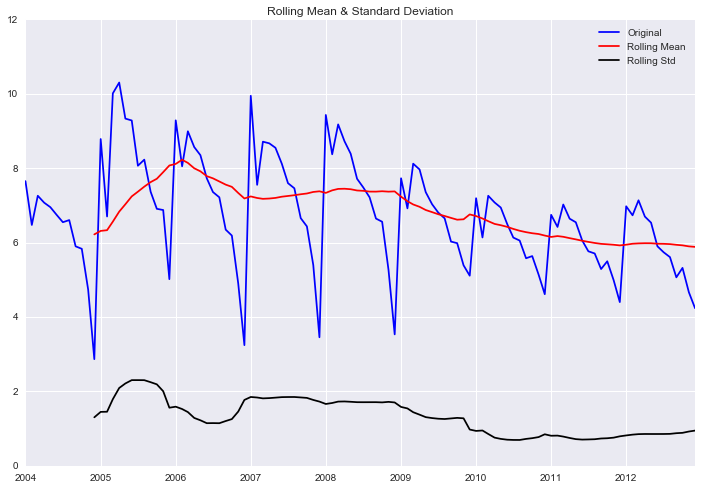

Results of Dickey-Fuller Test:
Test Statistic                 -0.959012
p-value                         0.767919
#Lags Used                     12.000000
Number of Observations Used    95.000000
Critical Value (1%)            -3.501137
Critical Value (5%)            -2.892480
Critical Value (10%)           -2.583275
dtype: float64


In [52]:
test_stationarity(datasets.Incidence_rate)

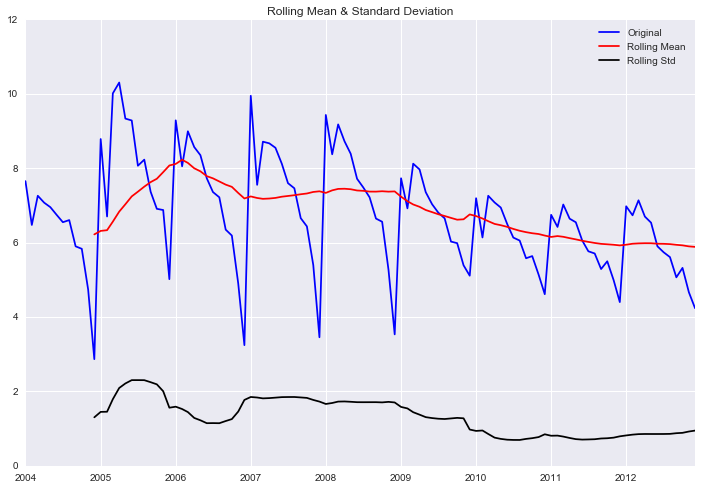

Results of Dickey-Fuller Test:
Test Statistic                 -0.959012
p-value                         0.767919
#Lags Used                     12.000000
Number of Observations Used    95.000000
Critical Value (1%)            -3.501137
Critical Value (5%)            -2.892480
Critical Value (10%)           -2.583275
dtype: float64


In [53]:
test_stationarity(datasets['Incidence_rate'])

### First difference

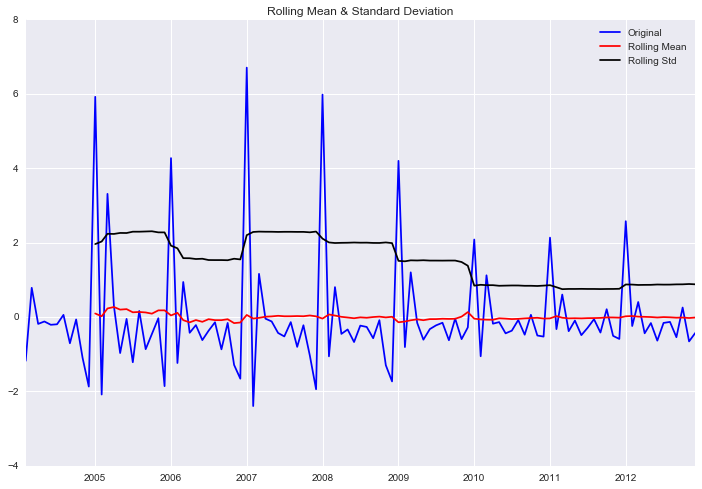

Results of Dickey-Fuller Test:
Test Statistic                 -3.540878
p-value                         0.006997
#Lags Used                     11.000000
Number of Observations Used    95.000000
Critical Value (1%)            -3.501137
Critical Value (5%)            -2.892480
Critical Value (10%)           -2.583275
dtype: float64


In [54]:
datasets['first_diff'] = datasets.Incidence_rate - datasets.Incidence_rate.shift(1)
test_stationarity(datasets.first_diff.dropna(inplace=False))

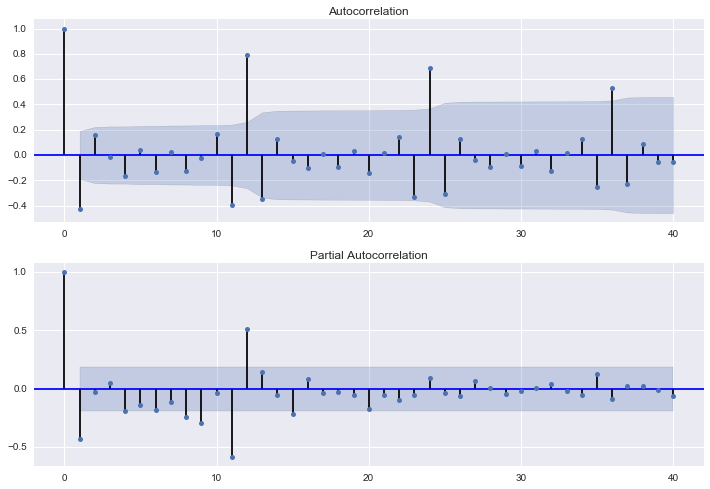

In [55]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(datasets.first_diff.iloc[1:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(datasets.first_diff.iloc[1:], lags=40, ax=ax2)

### Seasonal difference

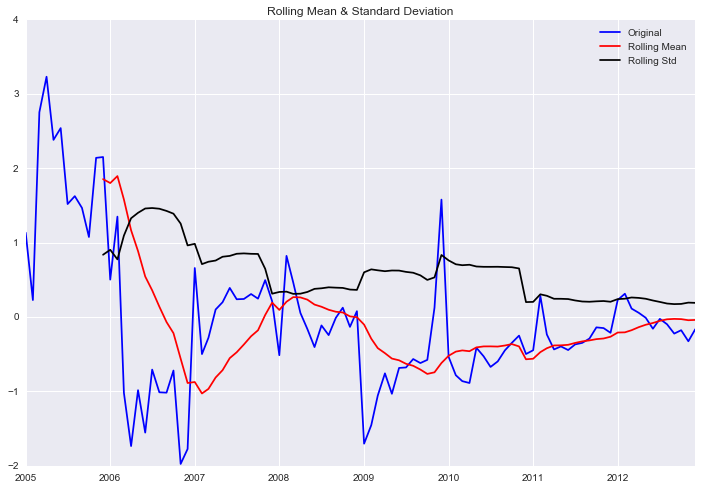

Results of Dickey-Fuller Test:
Test Statistic                 -3.854963
p-value                         0.002392
#Lags Used                      0.000000
Number of Observations Used    95.000000
Critical Value (1%)            -3.501137
Critical Value (5%)            -2.892480
Critical Value (10%)           -2.583275
dtype: float64


In [56]:
datasets['seasonal_difference'] = datasets.Incidence_rate - datasets.Incidence_rate.shift(12)  
test_stationarity(datasets.seasonal_difference.dropna(inplace=False))

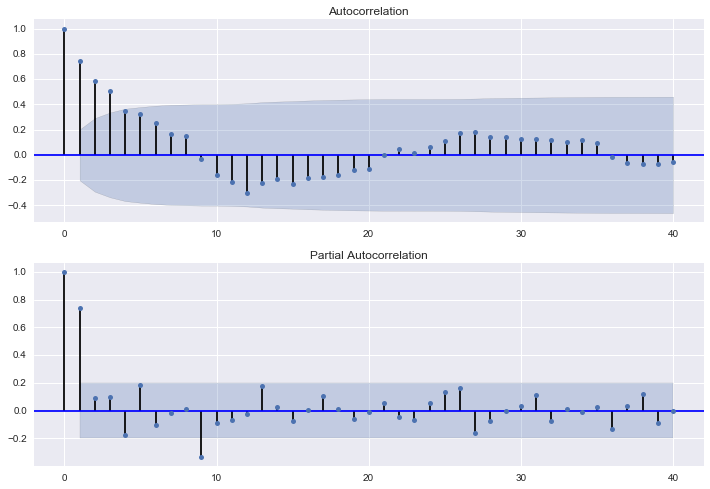

In [57]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(datasets.seasonal_difference.iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(datasets.seasonal_difference.iloc[13:], lags=40, ax=ax2)

In [58]:
mod = sm.tsa.SARIMAX(datasets.Incidence_rate, trend='n', order=(4,1,0), seasonal_order=(4,1,0,12))
results = mod.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                     Incidence_rate   No. Observations:                  108
Model:             SARIMAX(4, 1, 0)x(4, 1, 0, 12)   Log Likelihood                 -83.976
Date:                            Wed, 24 Aug 2016   AIC                            185.952
Time:                                    16:29:51   BIC                            210.091
Sample:                                01-01-2004   HQIC                           195.740
                                     - 12-01-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3418      0.095     -3.583      0.000      -0.529      -0.155
ar.L2         -0.2468      0.113   

### Seasonal first difference 

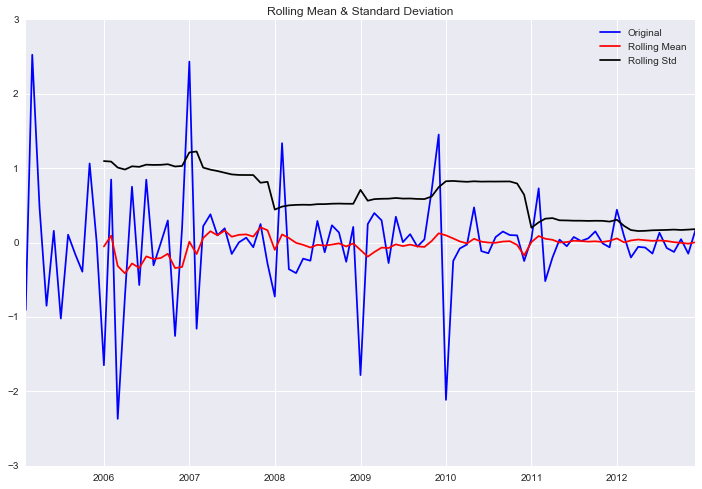

Results of Dickey-Fuller Test:
Test Statistic                -1.278283e+01
p-value                        7.352796e-24
#Lags Used                     0.000000e+00
Number of Observations Used    9.400000e+01
Critical Value (1%)           -3.501912e+00
Critical Value (5%)           -2.892815e+00
Critical Value (10%)          -2.583454e+00
dtype: float64


In [59]:
datasets['seasonal_first_difference'] = datasets.first_diff-datasets.first_diff.shift(12)
test_stationarity(datasets.seasonal_first_difference.dropna(inplace=False))

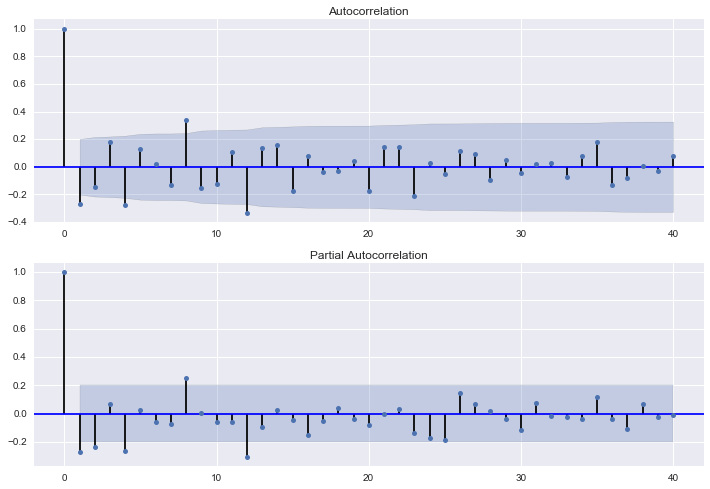

In [60]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(datasets.seasonal_first_difference.iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(datasets.seasonal_first_difference.iloc[13:], lags=40, ax=ax2)

## Bulid Model

In [61]:
mod = sm.tsa.SARIMAX(datasets.Incidence_rate, trend='n', order=(0,1,2), seasonal_order=(0,1,1,12))
results = mod.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                     Incidence_rate   No. Observations:                  108
Model:             SARIMAX(0, 1, 2)x(0, 1, 1, 12)   Log Likelihood                 -87.238
Date:                            Wed, 24 Aug 2016   AIC                            182.475
Time:                                    16:29:52   BIC                            193.204
Sample:                                01-01-2004   HQIC                           186.825
                                     - 12-01-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3750      0.084     -4.473      0.000      -0.539      -0.211
ma.L2         -0.1291      0.094   

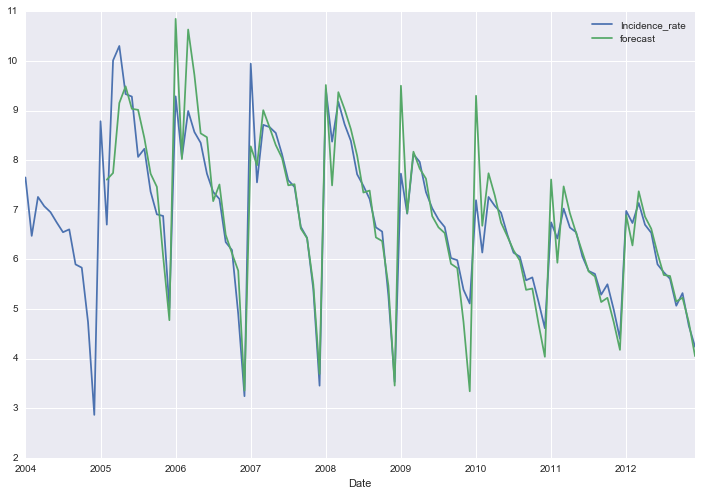

In [62]:
datasets['forecast'] = results.predict(start = 13, end= 131, dynamic= False)  
datasets[['Incidence_rate', 'forecast']].plot(figsize=(12, 8))

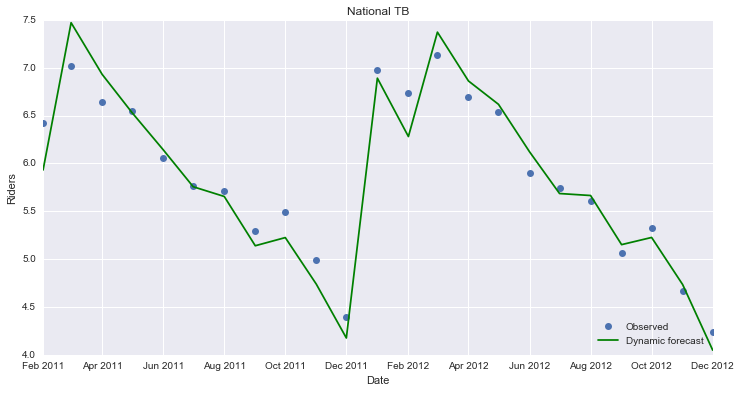

In [63]:
npredict =datasets.Incidence_rate['2004'].shape[0]
fig, ax = plt.subplots(figsize=(12,6))
npre = 12
ax.set(title='National TB', xlabel='Date', ylabel='Riders')
ax.plot(datasets.index[-npredict-npre+1:], datasets.ix[-npredict-npre+1:, 'Incidence_rate'], 'o', label='Observed')
ax.plot(datasets.index[-npredict-npre+1:], datasets.ix[-npredict-npre+1:, 'forecast'], 'g', label='Dynamic forecast')
legend = ax.legend(loc='lower right')
legend.get_frame().set_facecolor('w')

In [64]:
datasets_pred

,Area,Incidence,Death,Incidence_rate,Death_rate,Year,Month
Date,,,,,,,
2013-01-01,全 国,88539,233,6.538876,0.017208,2013,01
2013-02-01,全 国,76557,216,5.653969,0.015952,2013,02
2013-03-01,全 国,85255,238,6.296343,0.017577,2013,03
2013-04-01,全 国,84395,211,6.232829,0.015583,2013,04
2013-05-01,全 国,81852,237,6.045021,0.017503,2013,05
2013-06-01,全 国,75769,205,5.595773,0.015140,2013,06
2013-07-01,全 国,74805,247,5.524578,0.018242,2013,07
2013-08-01,全 国,73995,203,5.464757,0.014992,2013,08
2013-09-01,全 国,69323,206,5.119716,0.015214,2013,09


In [65]:
dta = pd.concat([datasets, datasets_pred])
dta.tail(12)

,Area,Death,Death_rate,Incidence,Incidence_rate,Month,Year,first_diff,forecast,seasonal_difference,seasonal_first_difference
Date,,,,,,,,,,,
2014-01-01,全 国,189,0.013947,89128,6.576894,01,2014,NaN,NaN,NaN,NaN
2014-02-01,全 国,178,0.013135,77153,5.693240,02,2014,NaN,NaN,NaN,NaN
2014-03-01,全 国,214,0.015791,84473,6.233394,03,2014,NaN,NaN,NaN,NaN
2014-04-01,全 国,230,0.016972,81543,6.017185,04,2014,NaN,NaN,NaN,NaN
2014-05-01,全 国,212,0.015644,79530,5.868642,05,2014,NaN,NaN,NaN,NaN
2014-06-01,全 国,182,0.013430,76366,5.635166,06,2014,NaN,NaN,NaN,NaN
2014-07-01,全 国,184,0.013578,74607,5.505367,07,2014,NaN,NaN,NaN,NaN
2014-08-01,全 国,188,0.013873,71144,5.249826,08,2014,NaN,NaN,NaN,NaN
2014-09-01,全 国,187,0.013799,67087,4.950454,09,2014,NaN,NaN,NaN,NaN


In [66]:
dta['forecast'] = results.predict(start=13,end=131,dynamic=False)
dta['forecast'].tail(13)

Date
2013-12-01    4.021098
2014-01-01    6.574665
2014-02-01    6.154940
2014-03-01    6.731647
2014-04-01    6.349470
2014-05-01    6.182681
2014-06-01    5.617934
2014-07-01    5.396289
2014-08-01    5.284541
2014-09-01    4.771054
2014-10-01    4.970017
2014-11-01    4.353239
2014-12-01    3.841260
Name: forecast, dtype: float64

In [67]:
output_notebook()
p = figure(x_axis_type="datetime", title='Nation TB Incidence Rate in China')
p.xgrid.grid_line_color=None
p.ygrid.grid_line_alpha=.5
p.line(dta.index, dta['Incidence_rate'], line_color="gray", line_dash="4 4", line_width=1)
p.circle(dta.index, dta['Incidence_rate'], size=6, color='olivedrab')
show(p)

Loading BokehJS ...

In [68]:
output_notebook()
pred = dta[dta.index>='2014-01-01']
p = figure(x_axis_type="datetime", title='Nation TB Incidence Rate in China')
p.xgrid.grid_line_color=None
p.ygrid.grid_line_alpha=.5
p.line(dta.index, dta['Incidence_rate'], line_color="gray", line_dash="4 4", line_width=1)
p.circle(dta.index, dta['Incidence_rate'], size=6, color='olivedrab')
p.scatter(pred.index,pred['forecast'],size=6,color='navy')
show(p)

Loading BokehJS ...

In [69]:
dta.tail(13)

,Area,Death,Death_rate,Incidence,Incidence_rate,Month,Year,first_diff,forecast,seasonal_difference,seasonal_first_difference
Date,,,,,,,,,,,
2013-12-01,全 国,195,0.014401,60399,4.460651,12,2013,NaN,4.021098,NaN,NaN
2014-01-01,全 国,189,0.013947,89128,6.576894,01,2014,NaN,6.574665,NaN,NaN
2014-02-01,全 国,178,0.013135,77153,5.693240,02,2014,NaN,6.154940,NaN,NaN
2014-03-01,全 国,214,0.015791,84473,6.233394,03,2014,NaN,6.731647,NaN,NaN
2014-04-01,全 国,230,0.016972,81543,6.017185,04,2014,NaN,6.349470,NaN,NaN
2014-05-01,全 国,212,0.015644,79530,5.868642,05,2014,NaN,6.182681,NaN,NaN
2014-06-01,全 国,182,0.013430,76366,5.635166,06,2014,NaN,5.617934,NaN,NaN
2014-07-01,全 国,184,0.013578,74607,5.505367,07,2014,NaN,5.396289,NaN,NaN
2014-08-01,全 国,188,0.013873,71144,5.249826,08,2014,NaN,5.284541,NaN,NaN


In [70]:
# dta.to_csv('/Users/Evan/Desktop/Nation TB Monthly.csv',encoding='GB2312')

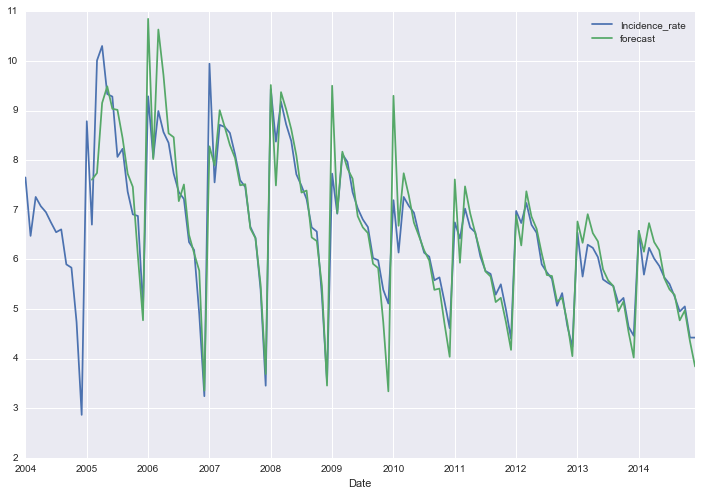

In [71]:
dta['forecast'] = results.predict(start = 13, end= 131, dynamic= False)  
dta[['Incidence_rate','forecast']].plot(figsize=(12, 8))

## SARIMA-GRNN Hybrid Model

## Load Packages

In [72]:
from sklearn import preprocessing as pp
from sklearn import cross_validation as cv
from neupy.algorithms import GRNN as grnn
from neupy.estimators import mse

In [73]:
data_train = dta.loc['2005-02-1':'2014-12-01'][['Incidence_rate','forecast','Month']]
data_train['Jan'] = data_train['Month']==1

x_train = data_train.loc[:'2012-12-01']['forecast']
y_train = data_train.loc[:'2012-12-01']['Incidence_rate']
x_test = data_train.loc['2013-01-01':]['forecast']
y_test = data_train['2013-01-01':]['Incidence_rate']

In [74]:
data_train

,Incidence_rate,forecast,Month,Jan
Date,,,,
2005-02-01,6.701542,7.607165,02,False
2005-03-01,10.011233,7.742094,03,False
2005-04-01,10.302798,9.153064,04,False
2005-05-01,9.333632,9.489210,05,False
2005-06-01,9.282781,9.036563,06,False
2005-07-01,8.066361,9.015037,07,False
2005-08-01,8.229684,8.447093,08,False
2005-09-01,7.365373,7.727834,09,False
2005-10-01,6.908408,7.463033,10,False


In [75]:
def try_std(x):
    nn = grnn(std =x ,verbose=False)
    nn.train(x_train,y_train)
    y_pred = nn.predict(x_test)
    print(mse(y_pred,y_test))

In [76]:
for x in np.linspace(0.3,0.6,10):
        print(x)
        try_std(x)
        print('--\n')

0.3
0.10785550800538907
--

0.333333333333
0.1076720982852682
--

0.366666666667
0.10756578321273548
--

0.4
0.1075054784610363
--

0.433333333333
0.10750797139332326
--

0.466666666667
0.10762838929464513
--

0.5
0.10793983355000313
--

0.533333333333
0.10851517064984224
--

0.566666666667
0.10941610149733298
--

0.6
0.1106889011898302
--



In [77]:
mod_GRNN = grnn(std = 0.4 ,verbose=False)
mod_GRNN.train(x_train,y_train)
data_train.loc[:,'NN']=mod_GRNN.predict(data_train['forecast'])

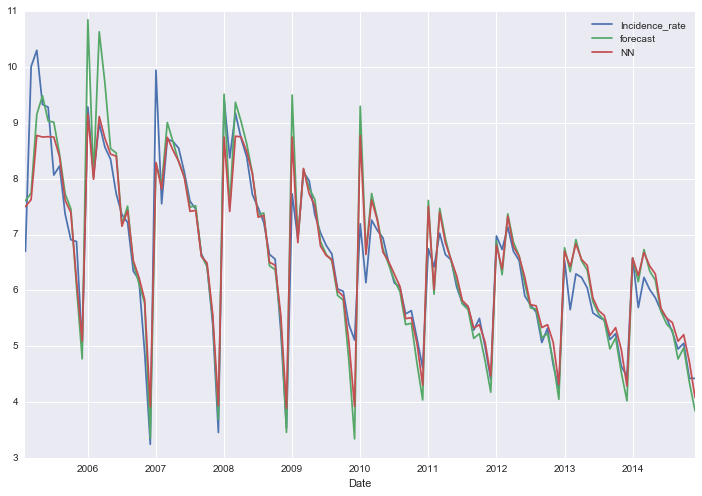

In [78]:
data_train[['Incidence_rate','forecast','NN']].plot(figsize=(12, 8)) 

In [79]:
data_train[['Incidence_rate','forecast','NN']]

## 绝对误差
data_train['Dist_ARIMA'] =abs(data_train['forecast']-data_train['Incidence_rate'])
data_train['Dist_GRNN'] = abs(data_train['NN']-data_train['Incidence_rate'])
data_train['Better'] = data_train['Dist_ARIMA']  - data_train['Dist_GRNN'] 

data_train['error_ARIMA'] = data_train['forecast']-data_train['Incidence_rate']
data_train['error_GRNN'] = data_train['NN']-data_train['Incidence_rate']

## 相对误差
data_train['ARIMA_per']  = (data_train['Dist_ARIMA']/data_train['Incidence_rate'])*100
data_train['GRNN_per'] = (data_train['Dist_GRNN']/data_train['Incidence_rate'])*100
np.mean(data_train['Dist_ARIMA'])
np.mean(data_train['Dist_GRNN'])
np.mean(data_train['ARIMA_per'])- np.mean(data_train['GRNN_per'])

0.50830403048712469

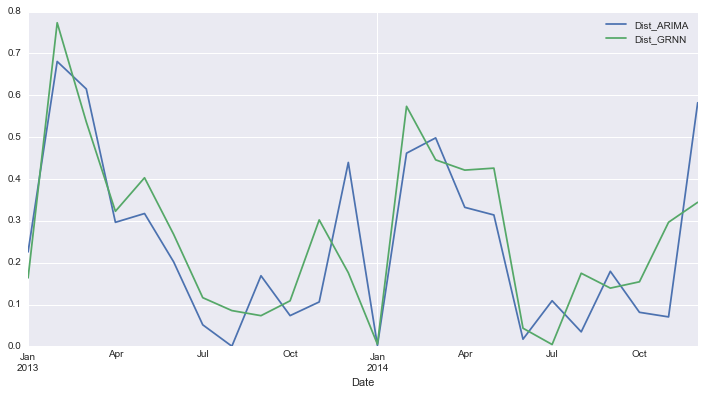

In [80]:
data_train[data_train.index>='2013-01-01'][['Dist_ARIMA','Dist_GRNN']].plot(figsize=(12,6))

In [81]:
data_out = data_train[data_train.index>='2013-01-01']

sum(data_out['ARIMA_per'])- sum(data_out['GRNN_per'])

np.mean(data_out['Dist_ARIMA'])-np.mean(data_out['Dist_GRNN'])

-0.020745639806972221

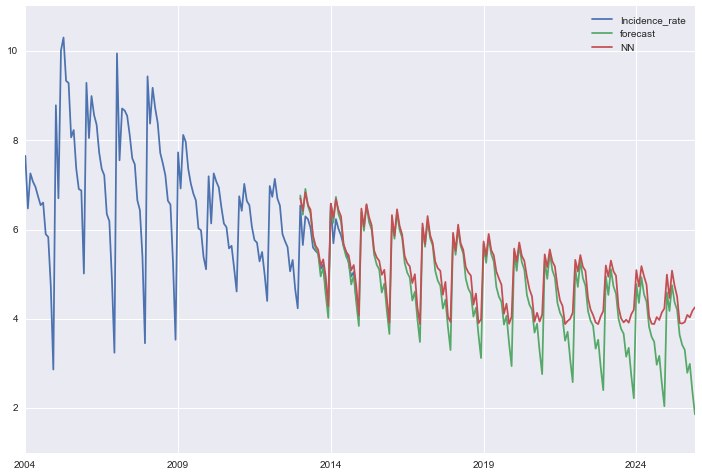

In [82]:
start = datetime.datetime.strptime("2015-01-01", "%Y-%m-%d")
date_list = [start + relativedelta(months=x) for x in range(0,132)]
future = pd.DataFrame(index=date_list, columns= dta.columns)
TB_future = pd.concat([dta, future])
TB_future['forecast'] = results.predict(start = 108, end = 263, dynamic= True)  
TB_future['NN'] = mod_GRNN.predict(TB_future['forecast'])
TB_future[['Incidence_rate', 'forecast','NN']].plot(figsize=(12, 8)) 

## Predict 2015-2025

In [83]:
TB_2025 = TB_future[TB_future.index>='2025-01-01']['forecast']

In [84]:
np.sum(TB_2025)

42.489021450805843